# Example: Payoff and Profit of Composite Contracts at Expiration
In this example, we will analyze the payoff and profit of composite contracts consisting of long (short) call (put) options contracts written on the same underlying asset with the same expiration date.

> __Learning Objectives__
> 
> By the end of this example, you should be able to:
> * __Compute profit diagrams__ for composite options strategies including vertical spreads, straddles, and strangles by combining individual option contract payoffs and premiums.
> * __Analyze directional strategies__ such as credit spreads that express bullish or bearish market views with defined risk profiles and breakeven points.
> * __Evaluate neutral strategies__ such as straddles and strangles that profit from significant price moves in either direction, with multiple breakeven points and undefined maximum loss potential.

Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [3]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

### Data
To start, load the options data using [the `MyOptionsChainDataSet(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyOptionsChainDataSet) and store the data in the `metadata::Dict{String,Any}` and `optionschain::DataFrame` variables.

In [6]:
metadata, optionschain = let
    
    # initialize -
    options_dataset = MyOptionsChainDataSet(ticker="amd");
    metadata = options_dataset.metadata;
    optionschain = options_dataset.data;

    (metadata, optionschain) # return
end;

What's in the metadata dictionary?

In [8]:
metadata |> keys

KeySet for a Dict{String, Any} with 10 entries. Keys:
  "DTE"
  "purchase_date"
  "historical_volatility"
  "underlying_share_price_ask"
  "source"
  "underlying_share_price_bid"
  "is_weekly"
  "atm_IV"
  "expiration_date"
  "underlying_share_price_mid"

What about the optionschain variable?

In [10]:
 optionschain

Row,Strike,Moneyness,Bid,Mid,Ask,Last,Volume,Open Int,IV,Delta,Type
,Float64,Float64,Float64,Float64,Float64,Float64,String7,String7,Float64,Float64,String7
1,25.0,0.8907,203.1,204.0,204.9,209.72,0,419,2.1122,0.9989,Call
2,30.0,0.8688,198.2,199.05,199.9,206.3,0,163,1.9784,0.9985,Call
3,35.0,0.847,193.2,193.98,194.75,199.75,0,17,0.0,0.0,Call
4,40.0,0.8251,188.3,189.1,189.9,176.24,0,18,1.6654,0.9985,Call
5,45.0,0.8033,183.25,184.13,185.0,174.11,0,318,1.5375,0.9985,Call
6,50.0,0.7814,178.4,179.1,179.8,167.46,0,691,1.2356,0.9996,Call
7,55.0,0.7596,173.35,174.13,174.9,177.43,0,176,1.0885,0.9998,Call
8,60.0,0.7377,168.5,169.3,170.1,162.15,0,332,1.3802,0.9967,Call
9,65.0,0.7158,163.45,164.33,165.2,175.38,0,180,1.2927,0.9967,Call


### Constants
Finally, let's set some constants we'll use later in this notebook. The comments describe the constants, their units, and permissible values:

In [12]:
Sₒ = metadata["underlying_share_price_mid"] |> x-> parse(Float64,x); # set the initial share price (this has no importance now because we have the options chain data)

___

## Task 1: Directional: Credit and Debit Vertical Spreads
[Vertical spreads](https://www.fidelity.com/bin-public/060_www_fidelity_com/documents/learning-center/Deck_Vertical-spreads.pdf), a defined risk directional strategy, involve buying and selling the same type of option with different strike prices and the same expiration date. Vertical spreads can be opened for a credit or debit and have defined risk.

### Bullish put credit spread
A put vertical spread is constructed by combining 2 $\times$ put contracts, a short put contract generates income while the long put contract controls downside risk. This trade has a bullish outlook on the underlying asset.

> __Bullish put credit spread:__ 
> 
> Let's build a bullish put credit spread for AMD whose current share price is $S(0) = 225.78$ USD/share. This trade structure is constructed by selling (short) a put with strike $K_{1}$ and buying (long) a put with strike $K_{2}$. 
> 
> * Leg 1: The strike price for the short put leg is given by $K_{1}$ = 220 USD/share with DTE = 58 days
> * Leg 2: The strike price for the long put leg is given by $K_{2}$ = 210 USD/share with DTE = 58 days
> 
> This trade will generate a net credit when opened. Depending on the share price at expiration, the trade can result in a profit or loss. The maximum profit occurs when the share price at expiration is above the higher strike price $K_{1}$. The maximum loss occurs when the share price at expiration is below the lower strike price $K_{2}$.


#### Profit and Breakeven Analysis
Let contract $j$ have a strike price of $K_{j}$ and premium $\mathcal{P}_{j}$. The share price at expiration is given by $S(T)$. Finally, let contract 1 be the short leg $\theta_{1} = -1$ and contract 2 be the long leg $\theta_{2} = 1$. Then, the profit for a single put vertical spread at expiration is given by:

$$\hat{P}_{\mathcal{C}} = -P_{1}^{(p)}+P_{2}^{(p)}$$

which, after substitution of the profit functions for a put contract, gives:

$$
\hat{P}_{\mathcal{C}} = \left(K_{2} - S(T)\right)^{+} - \left(K_{1} - S(T)\right)^{+} + \left(\mathcal{P}_{1} - \mathcal{P}_{2}\right)$$

where $V_{p}(K,S(T)) = (K-S(T))^{+}=\max(K-S(T),0)$ is the payoff function for a put contract. The first term is the net payout of the two legs of the spread, while the second term is the net cost of the two contracts. The maximum possible profit, loss, and breakeven conditions are given by:

* The maximum possible profit of $\left(\mathcal{P}_{1} - \mathcal{P}_{2}\right)$ will occur when $S(T)\geq{K_{1}}$.
* The maximum possible loss of $K_{2} - K_{1} + \left(\mathcal{P}_{1} - \mathcal{P}_{2}\right)$ will occur when $S(T)\leq{K_{2}}$.
* The vertical put spread will breakeven when $S(T) = K_{1}+\left(\mathcal{P}_{2} - \mathcal{P}_{1}\right)$.

To create a profit diagram, we first need to determine the strike prices for each trade leg (stored in the $K_{\star}$ variables).

We then [utilize `build(...)` methods](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.build-Tuple{Type{MyAmericanCallContractModel},%20NamedTuple}) to construct option contract models, and generate an array of share prices at expiration and store them in an array. 

Using [the `profit(...)` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/derivatives/#VLQuantitativeFinancePackage.profit), we calculate the profit for each leg and the overall trade. We also determine the breakeven points for the trade using analytical expressions and plot the share price versus the profit with the help [of the `plot(...)` functions from the `Plots.jl`](https://github.com/JuliaPlots/Plots.jl) package.

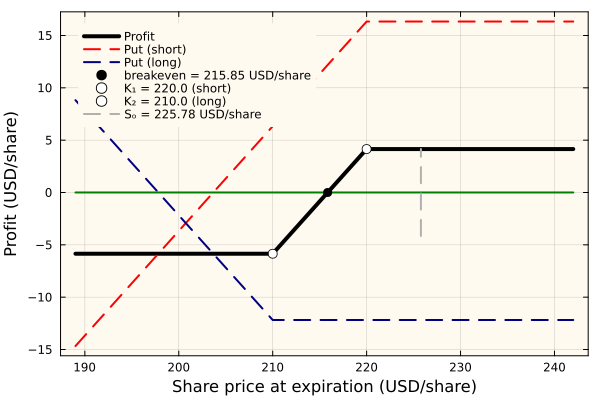

In [16]:
let

    # initialize -
    options_dataset =  optionschain;
    K₁ = 220.0 # short put strike price
    K₂ = 210.0 # long put strike price
    premium_1 = filter([:Strike,:Type] => (x,y) -> (x == K₁ && y == "Put"), options_dataset)[1,:Mid];
    premium_2 = filter([:Strike,:Type] => (x,y) -> (x == K₂ && y == "Put"), options_dataset)[1,:Mid];
     
    max_loss = K₂ - K₁ + (premium_1 - premium_2);
    max_profit = (premium_1 - premium_2);
    
    put_contract_model_short = build(MyAmericanPutContractModel, (
            K = K₁, premium = premium_1, sense = -1, copy = 1
    ));

    put_contract_model_long = build(MyAmericanPutContractModel, (
            K = K₂, premium = premium_2, sense = 1, copy = 1
    ));
    
    S = range(0.9*K₂,stop = 1.1*K₁, step=0.1) |> collect;
    number_of_steps = length(S);
    BEL = zeros(length(S))
    profit_array = profit([put_contract_model_short, put_contract_model_long], S);
    breakeven = K₁ + (premium_2 - premium_1)
    
    plot(profit_array[:,1], profit_array[:,4], lw=4, label="Profit", c=:black, 
        bg="floralwhite", 	background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    plot!(profit_array[:,1], profit_array[:,2], lw=2, label="Put (short)", ls=:dash, c=:red)
    plot!(profit_array[:,1], profit_array[:,3], lw=2, label="Put (long)", ls=:dash, c=:navyblue)
    
    plot!(S,BEL,lw=2, c=:green, label="")
    scatter!([breakeven], [0], c=:black, label="breakeven = $(breakeven) USD/share", ms=5)
    scatter!([K₁],[max_profit], ms=5, label = "K₁ = $(K₁) (short)", msc=:black, mc=:white)
    scatter!([K₂],[max_loss], ms=5, label = "K₂ = $(K₂) (long)", msc=:black, mc=:white)

    VLINE = zeros(number_of_steps, 2)
    VLINE[:,1] .= Sₒ*ones(number_of_steps)
    VLINE[:,2] .= range(minimum(-1*profit_array[:,end]), stop = maximum(profit_array[:,end]), length = number_of_steps) |> collect;
    plot!(VLINE[:,1], VLINE[:,2], lw=2, c= :gray69, ls=:dash, label="Sₒ = $(Sₒ) USD/share")
    
    xlabel!("Share price at expiration (USD/share)", fontsize=18)
    ylabel!("Profit (USD/share)", fontsize=18)
end

### Bearish call credit spread
A bearish call credit spread is an options strategy used when a trader expects a __decline__ in the price of the underlying asset. This trade structure is constructed by selling (short) a call with strike $K_{1}$ and buying (long) a call with strike $K_{2}$ with $K_{1}<K_{2}$. 

> __Bearish call credit spread__
> 
> Let's build a bearish call credit spread on AMD whose current share price is $S(0) = 225.78$ USD/share. 
> This trade structure is constructed by selling (short) a call with strike $K_{1}$ and buying (long) a call with strike $K_{2}$. 
> 
> * Leg 1: The strike price for the short call leg is given by $K_{1} = 210$ USD/share.
> * Leg 2: The strike price for the long call leg is given by $K_{2} = 240$ USD/share.
> 
> This trade has a bearish outlook on the underlying asset. This trade will generate a net credit when opened. Depending on the share price at expiration, the trade can result in a defined profit or loss. The maximum profit occurs when the share price at expiration is below the lower strike price $K_{1}$. The maximum loss occurs when the share price at expiration is above the higher strike price $K_{2}$.

#### Profit and Breakeven Analysis
The profit function for the bear call credit spread is given by:
$$
\hat{P}_{\mathcal{C}} = (S(T)-K_{2})^{+} - (S(T)-K_{1})^{+} + (\mathcal{P}_{1}-\mathcal{P}_{2})
$$

where $V_{c}(K,S(T)) = (S(T)-K)^{+}=\max(S(T)-K,0)$ is the payoff function for a call contract at expiration. The first two terms are the net payout of the two legs of the spread, while the last term is the net cost of the two contracts. The maximum possible profit, loss, and breakeven conditions are given by:

* The maximum possible profit of $\left(\mathcal{P}_{1} - \mathcal{P}_{2}\right)$ will occur when $S(T)\leq{K_{1}}$.
* The maximum possible loss of $\left(\mathcal{P}_{1} - \mathcal{P}_{2}\right) - (K_{2} - K_{1})$ will occur when $S(T)\geq{K_{2}}$.
* The bear call spread will breakeven when $S(T) = K_{1}+\left(\mathcal{P}_{1} - \mathcal{P}_{2}\right)$.

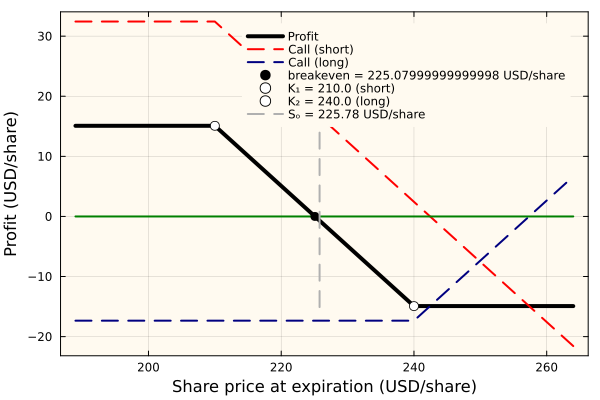

In [18]:
let

    # initialize -
    options_dataset =  optionschain;
    K₁ = 210.0 # short call strike price
    K₂ = 240.0 # long call strike price
    premium_1 = filter([:Strike,:Type] => (x,y) -> (x == K₁ && y == "Call"), options_dataset)[1,:Mid];
    premium_2 = filter([:Strike,:Type] => (x,y) -> (x == K₂ && y == "Call"), options_dataset)[1,:Mid];

    max_loss = (premium_1 - premium_2) - (K₂ - K₁)
    max_profit = (premium_1 - premium_2);
    
    call_contract_model_short = build(MyAmericanCallContractModel, (
            K = K₁, premium = premium_1, sense = -1, copy = 1
    ));

    call_contract_model_long = build(MyAmericanCallContractModel, (
            K = K₂, premium = premium_2, sense = 1, copy = 1
    ));
    
    S = range(0.9*K₁,stop = 1.1*K₂, step=0.1) |> collect;
    number_of_steps = length(S);
    BEL = zeros(length(S))
    profit_array = profit([call_contract_model_short, call_contract_model_long], S);
    breakeven = K₁ + (premium_1 - premium_2)
    
    plot(profit_array[:,1], profit_array[:,4], lw=4, label="Profit", c=:black, 
        bg="floralwhite", 	background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    plot!(profit_array[:,1], profit_array[:,2], lw=2, label="Call (short)", ls=:dash, c=:red)
    plot!(profit_array[:,1], profit_array[:,3], lw=2, label="Call (long)", ls=:dash, c=:navyblue)
    
    plot!(S,BEL,lw=2, c=:green, label="")
    scatter!([breakeven], [0], c=:black, label="breakeven = $(breakeven) USD/share", ms=5)
    scatter!([K₁],[max_profit], ms=5, label = "K₁ = $(K₁) (short)", msc=:black, mc=:white)
    scatter!([K₂],[max_loss], ms=5, label = "K₂ = $(K₂) (long)", msc=:black, mc=:white)

    VLINE = zeros(number_of_steps, 2)
    VLINE[:,1] .= Sₒ*ones(number_of_steps)
    VLINE[:,2] .= range(minimum(-1*profit_array[:,end]), stop = maximum(profit_array[:,end]), length = number_of_steps) |> collect;
    plot!(VLINE[:,1], VLINE[:,2], lw=2, c= :gray69, ls=:dash, label="Sₒ = $(Sₒ) USD/share")
    
    xlabel!("Share price at expiration (USD/share)", fontsize=18)
    ylabel!("Profit (USD/share)", fontsize=18)
end

___

## Task 2: Neutral: Straddles and Strangles
In this task, we will analyze two neutral option strategies: straddles and strangles. Straddles involve simultaneously buying (or selling) a put and a call option with the same strike price, while strangles use different strike prices.

### Straddles
A [straddle](https://www.investopedia.com/terms/s/straddle.asp) is a _neutral strategy_ constructed by simultaneously buying (or selling) a put and a call option on the same underlying asset `XYZ`, with the _same expiration_, and the _same strike price_. 

> __Long (short) straddle__
> 
> Let's build a long (short) straddle on AMD whose current share price is $S(0) = 225.78$ USD/share. For a long straddle, we purchase (are long) both the put and the call contracts in the straddle ($\theta = 1$). For a short straddle, we sell (are short) both the put and the call contracts in the straddle ($\theta = -1$). For a straddle, both legs have the same strike price $K$.
>
> Let's construct the profit diagram for a long (short) straddle with the parameters:
> * Leg 1: The strike price for the long (short) put leg is given by $K_{1}$ = 230 USD/share with DTE = 58 days
> * Leg 2: The strike price for the long (short) call leg is given by $K_{2}$ = 230 USD/share with DTE = 58 days
> 
> A [straddle](https://www.investopedia.com/terms/s/straddle.asp) can be initiated as a credit or debit:
> * **Long straddle** ($\theta = 1$): Maximum loss is limited to the total premium paid; profit is unlimited if the price moves significantly in either direction.
> * **Short straddle** ($\theta = -1$): Maximum profit is limited to the total premium collected; loss is unlimited if the price moves significantly in either direction.
> 
> In this example, we demonstrate a **short straddle** ($\theta = -1$) showing the profit/loss dynamics when both legs are sold.

#### Profit and Breakeven Analysis
Let $K_{j}$ denote the strike price of contract $j$ (USD/share), where the premium of contract $j$ is $\mathcal{P}_{j}$ (USD/share). Finally, let index $j=1$ denote the put contract, $j=2$ denote the call contract; for a straddle $K_{1}= K_{2}\equiv{K}$ (both legs have the same strike). The profit for a single straddle composite contract $\hat{P}_{\mathcal{C}}$ at expiration is given by:

$$\hat{P}_{\mathcal{C}} = \theta\cdot\left(P_{1}^{(p)}+P_{2}^{(c)}\right)$$

where $\theta_{1}=\theta_{2}\equiv\theta$ denotes a direction parameter: $\theta=-1$ if each leg is sold (short), $\theta=1$ otherwise. After substitution of the profit functions for a put and a call contract, the overall profit $\hat{P}_{\mathcal{C}}$ is given by:

$$\hat{P}_{\mathcal{C}} = \theta\cdot\Bigl[(K-S(T))^{+}+(S(T)-K)^{+}-(\mathcal{P}_{1}+\mathcal{P}_{2})\Bigr]$$

where $V_{p}(K,S(T)) = (K-S(T))^{+}=\max(K-S(T),0)$ is the payoff function for the put contract, and $V_{c}(K,S(T)) = (S(T)-K)^{+} = \max(S(T)-K,0)$ is the payoff function for the call contract. The profit (or loss) of a straddle has three regimes given by:

$$
\hat{P}_{\mathcal{C}} = \begin{cases}
  \theta\cdot\Bigl[(S(T)-K)-\left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)\Bigr]  & S(T)>K \\
  -\theta\cdot\Bigl[\mathcal{P}_{1}+\mathcal{P}_{2}\Bigr] & S(T)=K \\
    \theta\cdot\Bigl[(K-S(T))-\left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)\Bigr] & S(T)<K
\end{cases}
$$

Finally, a straddle has _two_ possible breakeven points denoted as $S^{+}$ and $S^{-}$:
* If $S(T)>K$: a straddle will breakeven at $S^{+} = K + \left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)$
* If $S(T)<K$: a straddle will breakeven at $S^{-} = K - \left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)$.

So what do we see?

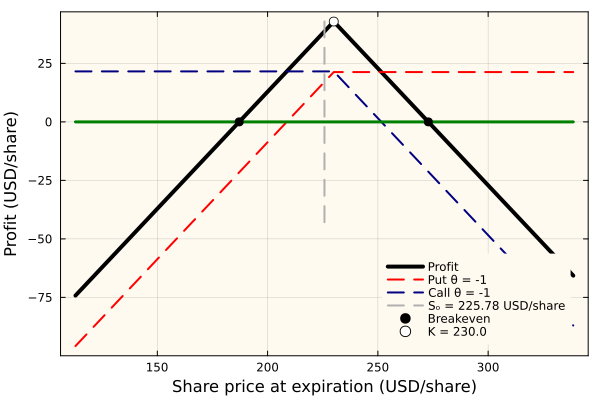

In [21]:
let
    
    # initialize -
    options_dataset =  optionschain;
    θ = -1; # 1 = long straddle, -1 = short straddle
    K = 230.0; # strike price
    δ = 0.50; # range parameter for plotting
    premium_1 = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Put"), options_dataset)[1,:Mid];
    premium_2 = filter([:Strike,:Type] => (x,y) -> (x == K && y == "Call"), options_dataset)[1,:Mid];

    max_loss = -1*θ*(premium_1 + premium_2);
    
    put_contract_model = build(MyAmericanPutContractModel, (
            K = K, premium = premium_1, sense = θ, copy = 1
    ));

    call_contract_model = build(MyAmericanCallContractModel, (
            K = K, premium = premium_2, sense = θ, copy = 1
    ));

    S = range((1-δ)*Sₒ,stop = (1+δ)*Sₒ, step=0.1) |> collect;
    number_of_steps = length(S);
    BEL = zeros(length(S))
    profit_array = profit([put_contract_model, call_contract_model], S);
    
    breakeven_array = zeros(2,2);
    breakeven_array[1,1] = K + (premium_1 + premium_2);
    breakeven_array[2,1] = K - (premium_1 + premium_2);
    
    plot(profit_array[:,1], profit_array[:,4], lw=4, label="Profit", c=:black, 
        bg="floralwhite", 	background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    plot!(profit_array[:,1], profit_array[:,2], lw=2, label="Put θ = $(θ)", ls=:dash, c=:red)
    plot!(profit_array[:,1], profit_array[:,3], lw=2, label="Call θ = $(θ)", ls=:dash, c=:navyblue)
    plot!(S,BEL,lw=3, c=:green, label="")
    
    VLINE = zeros(number_of_steps, 2)
    VLINE[:,1] .= Sₒ*ones(number_of_steps)
    VLINE[:,2] .= range(minimum(-1*profit_array[:,end]), stop = maximum(profit_array[:,end]), length = number_of_steps) |> collect;
    plot!(VLINE[:,1], VLINE[:,2], lw=2, c= :gray69, ls=:dash, label="Sₒ = $(Sₒ) USD/share")
    
    scatter!(breakeven_array[:,1], breakeven_array[:,2], c=:black, label="Breakeven", ms=5)
    scatter!([K],[max_loss], ms=5, label = "K = $(K)", msc=:black, mc=:white)
    
    xlabel!("Share price at expiration (USD/share)", fontsize=18)
    ylabel!("Profit (USD/share)", fontsize=18)
end

### Strangles
A [strangle](https://www.investopedia.com/terms/s/strangle.asp) position is a _neutral strategy_ constructed by simultaneously buying or selling a put and a call option on the same underlying asset `XYZ`, with the _same expiration_ but with _different strike prices_. 

> __Long (short) Strangle:__
> 
> Let's build a long (short) strangle on AMD whose current share price is $S(0) = 225.78$ USD/share. For a long (short) strangle, we purchase (are long) both the put and the call contracts in the strangle ($\theta = 1$). For a short strangle, we sell (are short) both the put and the call contracts in the strangle ($\theta = -1$). The strike price for the put contract $K_{1}$ is less than the strike price for the call contract $K_{2}$. 
> 
>  Let's construct the profit diagram for a long (short) strangle with the parameters:
> * Leg 1: The strike price for the long (short) put leg is given by $K_{1}$ = 210 USD/share with DTE = 58 days
> * Leg 2: The strike price for the long (short) call leg is given by $K_{2}$ = 240 USD/share with DTE = 58 days
> 
> A [strangle](https://www.investopedia.com/terms/s/strangle.asp) can be initiated as a credit or debit:
> * **Long strangle** ($\theta = 1$): Maximum loss is limited to the total premium paid; profit is unlimited if the price moves significantly beyond either strike.
> * **Short strangle** ($\theta = -1$): Maximum profit is limited to the total premium collected; loss is unlimited if the price moves significantly beyond either strike.
> 
> In this example, we demonstrate a **short strangle** ($\theta = -1$) showing the profit/loss dynamics when both legs are sold. 

#### Profit and Breakeven Analysis
Let $K_{j}$ denote the strike price of contract $j$ (USD/share), where the premium of contract $j$ is $\mathcal{P}_{j}$ (USD/share). Finally, let index $j=1$ denote the put contract, $j=2$ denote the call contract; for a strangle $K_{1}<K_{2}$. The profit for a single strangle composite contract $\hat{P}_{\mathcal{C}}$ at expiration is given by:

$$\hat{P}_{\mathcal{C}} = \theta\cdot\left(P_{1}^{(p)}+P_{2}^{(c)}\right)$$

where $\theta_{1}=\theta_{2}\equiv\theta$ denotes a direction parameter: $\theta=-1$ if each leg is sold (short), $\theta=1$ otherwise. After substitution of the profit functions for a put and a call contract, the overall profit $\hat{P}_{\mathcal{C}}$ is given by:

$$\hat{P}_{\mathcal{C}} = \theta\cdot\Bigl[(K_{1}-S(T))^{+}+(S(T)-K_{2})^{+}-(\mathcal{P}_{1}+\mathcal{P}_{2})\Bigr]$$

where $V_{p}(K_{1},S(T)) = (K_{1}-S(T))^{+}=\max(K_{1}-S(T),0)$ is the payoff for the put contract, and $V_{c}(K_{2},S(T)) = (S(T)-K_{2})^{+} = \max(S(T)-K_{2},0)$ is the payoff for the call contract. The profit (or loss) of a strangle has three regimes given by:

$$
\hat{P}_{\mathcal{C}} = \begin{cases}
  \theta\cdot\Bigl[(S(T)-K_{2})-\left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)\Bigr]  & S(T)>K_{2} \\
  -\theta\cdot\Bigl[\mathcal{P}_{1}+\mathcal{P}_{2}\Bigr] & K_{1}\leq{S(T)}\leq{K_{2}} \\
  \theta\cdot\Bigl[(K_{1}-S(T))-\left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)\Bigr] & S(T)<{K_{1}}
\end{cases}
$$

A [strangle](https://www.investopedia.com/terms/s/strangle.asp) has two break-even points $S^{+}$ and $S^{-}$ where $K_{2}<S^{+}$ and $S^{-}<K_{1}$. The low break-even point $S^{-}$ is given by:

$$S^{-} = K_{1} - \left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)$$

while the high break-even point $S^{+}$ is given by:

$$S^{+} = K_{2} + \left(\mathcal{P}_{1}+\mathcal{P}_{2}\right)$$

What does a long (short) strangle profit diagram look like?

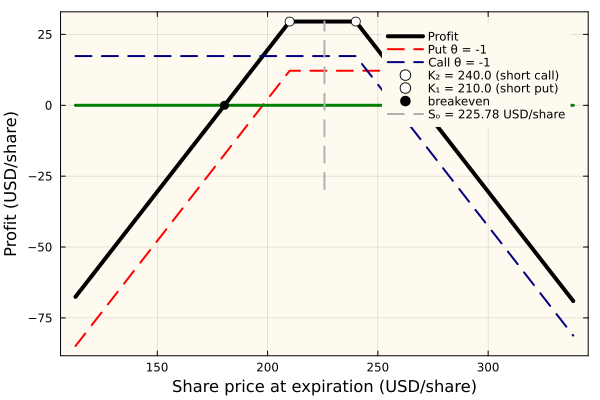

In [23]:
let

    # initialize -
    options_dataset =  optionschain;
    θ = -1; # 1 = long strangle, -1 = short strangle
    K₁ = 210.0;
    K₂ = 240.0;
    δ = 0.50; # range parameter for plotting
    premium_1 = filter([:Strike,:Type] => (x,y) -> (x == K₁ && y == "Put"), options_dataset)[1,:Mid];
    premium_2 = filter([:Strike,:Type] => (x,y) -> (x == K₂ && y == "Call"), options_dataset)[1,:Mid];
    
    max_loss = -1*θ*(premium_1 + premium_2);
    
    put_contract_model = build(MyAmericanPutContractModel, (
            K = K₁, premium = premium_1, sense = θ, copy = 1
    ));

    call_contract_model = build(MyAmericanCallContractModel, (
            K = K₂, premium = premium_2, sense = θ, copy = 1
    ));
    
    S = range((1-δ)*Sₒ,stop = (1+δ)*Sₒ, step=0.1) |> collect;
    number_of_steps = length(S);
    BEL = zeros(length(S))
    profit_array = profit([put_contract_model, call_contract_model], S);
    
    breakeven_array = zeros(2,2);
    breakeven_array[1,1] = K₂ + (premium_1 + premium_2);
    breakeven_array[2,1] = K₁ - (premium_1 + premium_2);
    
    plot(profit_array[:,1], profit_array[:,4], lw=4, label="Profit", c=:black, 
        bg="floralwhite", 	background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    plot!(profit_array[:,1], profit_array[:,2], lw=2, label="Put θ = $(θ)", ls=:dash, c=:red)
    plot!(profit_array[:,1], profit_array[:,3], lw=2, label="Call θ = $(θ)", ls=:dash, c=:navyblue)
    
    scatter!([K₂],[max_loss], ms=5, label = "K₂ = $(K₂) (short call)", msc=:black, mc=:white)
    scatter!([K₁],[max_loss], ms=5, label = "K₁ = $(K₁) (short put)", msc=:black, mc=:white)
    
    plot!(S,BEL,lw=3, c=:green, label="")
    scatter!(breakeven_array[:,1], breakeven_array[:,2], c=:black, label="breakeven", ms=5)
    
    VLINE = zeros(number_of_steps, 2)
    VLINE[:,1] .= Sₒ*ones(number_of_steps)
    VLINE[:,2] .= range(minimum(-1*profit_array[:,end]), stop = maximum(profit_array[:,end]), length = number_of_steps) |> collect;
    plot!(VLINE[:,1], VLINE[:,2], lw=2, c= :gray69, ls=:dash, label="Sₒ = $(Sₒ) USD/share")
    
    xlabel!("Share price at expiration (USD/share)", fontsize=18)
    ylabel!("Profit (USD/share)", fontsize=18)
end

___

## Summary
This example demonstrates how to construct and analyze composite options strategies by combining multiple option contracts to achieve specific risk-reward profiles.

> __Key Takeaways:__
> 
> * __Directional spreads__ such as bullish put credit spreads and bearish call credit spreads provide defined risk strategies that profit from moderate price moves in a specific direction, with maximum profit limited to the net credit received and maximum loss determined by the strike price differential.
> * __Neutral strategies__ such as straddles and strangles are structured differently depending on position direction: **long positions** have defined maximum loss (limited to premium paid) and unlimited profit potential from large price moves; **short positions** have defined maximum profit (limited to premium collected) and unlimited loss potential if the price moves significantly. Both feature multiple breakeven points, allowing traders to profit from volatility.
> * __Profit analysis__ requires combining individual contract payoffs with net premium costs, with breakeven calculations depending on the strategy type and directional assumptions of the composite position.

These composite strategies allow traders to express sophisticated market views while managing risk through defined loss limits and premium collection.
___

## Disclaimer and Risks

__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team.

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.